# **NDTS TEAM**

# **Permasalahan**

Era digital telah membawa kita ke dalam revolusi industri 4.0, di mana data menjadi aset paling
berharga. Kemampuan untuk mengolah, menganalisis, dan mengekstrak wawasan dari data (ilmu data)
menjadi kompetensi krusial di berbagai sektor, tidak terkecuali industri otomotif. Industri otomotif di
Indonesia merupakan salah satu pilar ekonomi nasional yang sangat dinamis.

Memahami dan
memprediksi tren penjualan mobil menjadi kunci bagi para pemangku kepentingan untuk merumuskan
strategi bisnis yang efektif.
Sejalan dengan visi Aptikom untuk memajukan kualitas pendidikan dan inovasi di bidang
teknologi informasi dan komputer, kami dengan bangga mempersembahkan Pesta Data Nasional
(Pedas) 2025.

Kompetisi ini dirancang untuk menjadi wadah bagi para mahasiswa dari seluruh
Indonesia untuk mengasah kemampuan mereka dalam bidang time series forecasting, sebuah cabang
ilmu data yang fundamental untuk peramalan. Dengan menggunakan data penjualan mobil dari
GAIKINDO, peserta ditantang untuk membangun model prediksi terbaik yang tidak hanya akurat, tetapi
juga inovatif.

# **Dataset**

Data yang digunakan dalam kompetisi Pesta Data Nasional (Pedas) 2025 merupakan data forecasting penjualan mobil periode tahun 2021–2025, yang disediakan oleh panitia dari https://www.gaikindo.or.id/indonesian-automobile-industry-data/ dalam bentuk file CSV (dataCarSale2021-2025.csv).
Selain itu, kami juga menambahkan data historis penjualan mobil dari tahun 2015–2020 yang diperoleh dari sumber yang sama dalam bentuk file CSV (dataCarSale2015-2025.csv), dengan tujuan memperkaya data latih (training data) agar model dapat menghasilkan prediksi yang lebih akurat.

Struktur Data (CSV)
File dataCarSale2021-2025.csv berisi 54 baris dan file dataCarSale2015-2025.csv berisi 126 baris dengan kolom-kolom sebagai berikut:


*   waktu : berisi informasi periode waktu dalam format tahun-bulan-tanggal.
*   DAIHATSU : total penjualan bulanan untuk merek Daihatsu.
*   HONDA : total penjualan bulanan untuk merek Honda.
*   MITSUBISHI : total penjualan bulanan untuk merek Mitsubishi.
*   SUZUKI : total penjualan bulanan untuk merek Suzuki.
*   TOYOTA : total penjualan bulanan untuk merek Toyota.


# **Output**

Hasil prediksi disimpan dalam sebuah file CSV dengan format kolom sebagai berikut:


*   Brand : merek mobil yang diprediksi.
*   Sales : jumlah penjualan hasil prediksi.


In [ ]:
# Import library

import pandas as pd
import numpy as np
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split
import warnings
import matplotlib.pyplot as plt

warnings.filterwarnings("ignore")

In [ ]:
# Membaca dan menampilkan file csv

import pandas as pd

df = pd.read_csv('/content/dataCarSale2015-2025.csv', sep=';')
df.head()

,waktu,DAIHATSU,HONDA,MITSUBISHI,SUZUKI,TOYOTA
0,2015-01-01,27166,16855,11365,12683,27166
1,2015-02-01,14523,13682,11220,10017,26743
2,2015-03-01,16238,13951,10212,12387,31801
3,2015-04-01,14855,10583,9662,8019,30053
4,2015-05-01,14486,11301,9126,10017,23223


In [ ]:
# Memeriksa jumlah data di file csv

print(df.shape[0])

126


In [ ]:
# Mengganti data '-' menjadi 0

import pandas as pd

df_clean = df.copy()

brand_columns = ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']
changed_data = {}

for col in brand_columns:
    if col in df_clean.columns:
        mask = (df_clean[col] == '-')
        if mask.any():
            original_values = df_clean.loc[mask, col].copy()
            df_clean[col] = df_clean[col].replace('-', 0)
            changed_values = df_clean.loc[mask, col].copy()
            changed_data[col] = pd.DataFrame({
                'Original': original_values,
                'Changed': changed_values
            })

print("Data yang diganti dari '-' menjadi 0:")
if changed_data:
    for col, data in changed_data.items():
        print(f"\nKolom: {col}")
        print(data)
else:
    print("Tidak ada data yang diganti.")

Data yang diganti dari '-' menjadi 0:

Kolom: DAIHATSU
   Original Changed
64        -       0


In [ ]:
# Memeriksa tipe data df_clean

df_clean.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 126 entries, 0 to 125
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   waktu       126 non-null    object
 1   DAIHATSU    126 non-null    object
 2   HONDA       126 non-null    int64 
 3   MITSUBISHI  126 non-null    int64 
 4   SUZUKI      126 non-null    int64 
 5   TOYOTA      126 non-null    int64 
dtypes: int64(4), object(2)
memory usage: 6.0+ KB


In [ ]:
import numpy as np

# --- Konversi waktu ke datetime dan set index ---
df_clean['waktu'] = pd.to_datetime(df_clean['waktu'], errors='coerce')
df_clean = df_clean.dropna(subset=['waktu'])
df_clean.set_index('waktu', inplace=True)

# --- Ubah kolom angka ke numeric ---
for col in brand_columns:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

In [ ]:
# Menerapkan Moving Average untuk mengisi nilai 0

window_size = 3

for col in brand_columns:
    if col in df_clean.columns:
        df_clean[col] = df_clean[col].replace(0, np.nan)
        rolling_mean = df_clean[col].rolling(window=window_size, min_periods=1, center=True).mean()
        df_clean[col] = df_clean[col].fillna(rolling_mean)
        df_clean[col] = df_clean[col].fillna(method='bfill').fillna(method='ffill')
        df_clean[col] = df_clean[col].round().astype(int)

print("\nContoh data setelah imputasi Moving Average:")
print(df_clean.iloc[60:70])


Contoh data setelah imputasi Moving Average:
            DAIHATSU  HONDA  MITSUBISHI  SUZUKI  TOYOTA
waktu                                                  
2020-01-01     14173  12777        9179   10512   24119
2020-02-01     15778  11373        7811    8613   25053
2020-03-01     18162  12068        7582    5085   26191
2020-04-01      1330   1183         808    1042    2053
2020-05-01       830    101         785     779     695
2020-06-01       331   1267        1767    2755    3705
2020-07-01      1553   2016        3564    6369    7224
2020-08-01      6651   3047        3208    3501    8673
2020-09-01     11204   5856        4230    6246   13150
2020-10-01      8289   7732        5315    5143   16345


In [ ]:
# Melengkapi bulan yang hilang dengan nilai 0, dan memastikan setiap tahun memiliki 12 bulan

import pandas as pd

full_range = pd.date_range(start=df_clean.index.min(), end=df_clean.index.max(), freq='MS')
df_full = df_clean.reindex(full_range).fillna(0)

df_full.index.name = 'waktu'

print("Total data sebelum ditambahkan:", df_clean.shape[0])
print("Total data sesudah ditambahkan:", df_full.shape[0])

check = df_full.groupby(df_full.index.year).size()
print("\nJumlah bulan tiap tahun:\n", check)

incomplete_years = check[check != 12]
print("\nTahun yang tidak lengkap:\n", incomplete_years)

missing_months = full_range.difference(df_clean.index)
print("\nBulan yang ditambahkan dengan nilai 0:")
print(missing_months)

Total data sebelum ditambahkan: 126
Total data sesudah ditambahkan: 127

Jumlah bulan tiap tahun:
 waktu
2015    12
2016    12
2017    12
2018    12
2019    12
2020    12
2021    12
2022    12
2023    12
2024    12
2025     7
dtype: int64

Tahun yang tidak lengkap:
 waktu
2025    7
dtype: int64

Bulan yang ditambahkan dengan nilai 0:
DatetimeIndex(['2023-12-01'], dtype='datetime64[ns]', name='waktu', freq='MS')


In [ ]:
# Update nilai pada 2023-12-01 sesuai data dari Gaikindo Wholesales 2023

df_full.loc[pd.Timestamp("2023-12-01"), ['DAIHATSU', 'HONDA', 'MITSUBISHI', 'SUZUKI', 'TOYOTA']] = [
    12805, 8423, 6330, 7402, 32041
]

print("Data setelah update Desember 2023:")
print(df_full.loc["2023-12-01"])

Data setelah update Desember 2023:
DAIHATSU      12805.0
HONDA          8423.0
MITSUBISHI     6330.0
SUZUKI         7402.0
TOYOTA        32041.0
Name: 2023-12-01 00:00:00, dtype: float64


In [ ]:
# Memeriksa tipe data df_full

df_full.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 127 entries, 2015-01-01 to 2025-07-01
Freq: MS
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   DAIHATSU    127 non-null    float64
 1   HONDA       127 non-null    float64
 2   MITSUBISHI  127 non-null    float64
 3   SUZUKI      127 non-null    float64
 4   TOYOTA      127 non-null    float64
dtypes: float64(5)
memory usage: 10.0 KB


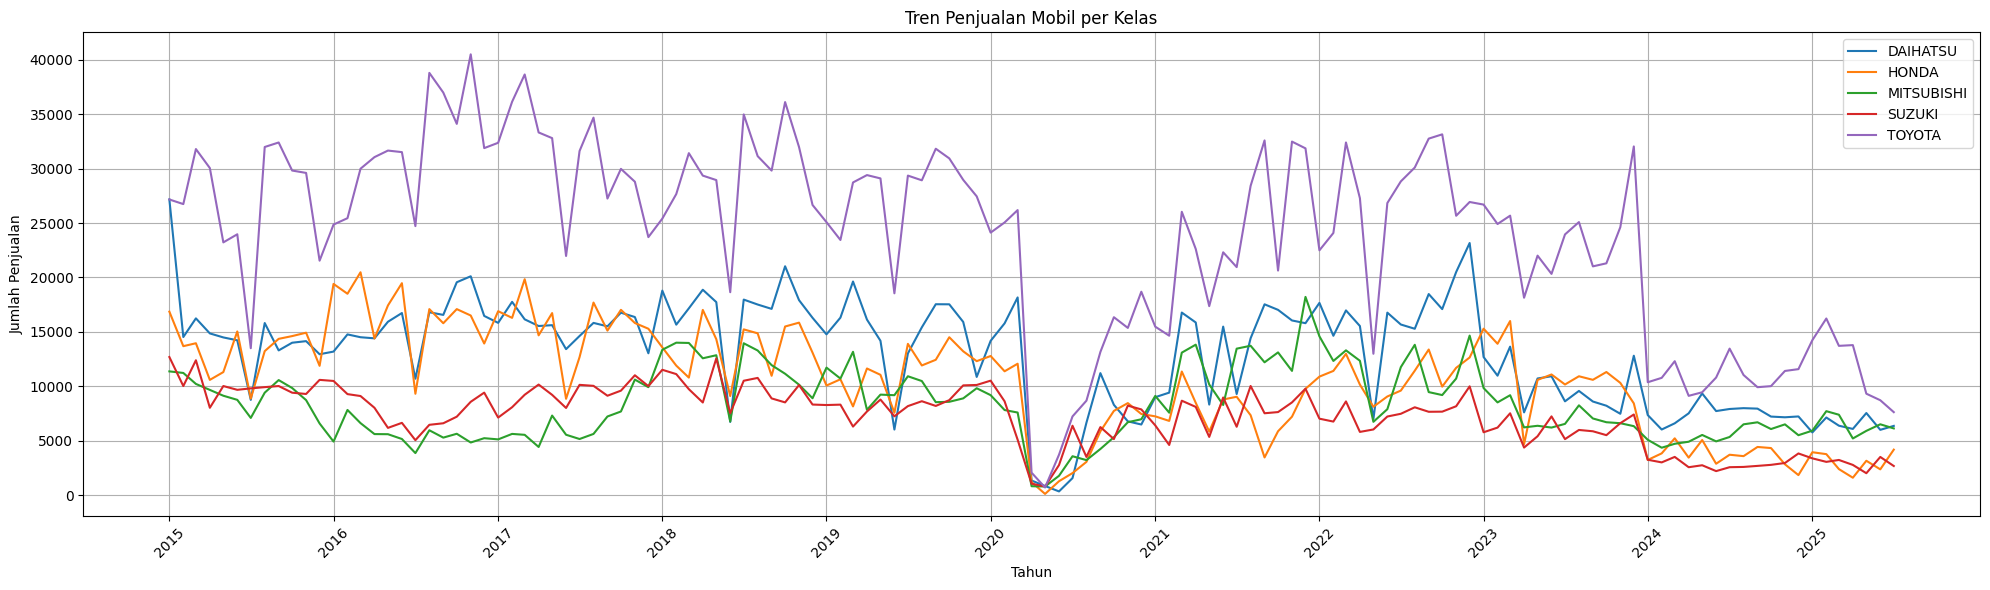

In [ ]:
# Menampilkan plot tren penjualan mobil per kelas

import matplotlib.pyplot as plt

plt.figure(figsize=(20, 6))

for col in df_full.columns:
    plt.plot(df_full.index, df_full[col], label=col)

plt.title('Tren Penjualan Mobil per Kelas')
plt.xlabel('Tahun')
plt.ylabel('Jumlah Penjualan')

years = pd.date_range(start=df_full.index.min(), end=df_full.index.max(), freq='YS')
plt.xticks(years, [d.year for d in years], rotation=45)

plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Target prediksi bulan Agustus

future_target_date = pd.Timestamp("2025-08-01")
results = []

In [ ]:
# Ensemble Forecasting (ARIMA, Prophet, LightGBM) dengan Bias Correction Khusus Toyota

for merek in df_full.columns:
    print(f"Processing {merek}...")
    series = df_full[merek].astype(float).dropna()

    # ARIMA
    try:
        arima_model = ARIMA(series, order=(1,1,1)).fit()
        arima_pred = arima_model.forecast(steps=1)[0]
        arima_val = arima_model.forecast(steps=6)
        arima_mae = mean_absolute_error(series[-6:], arima_val[:len(series[-6:])])
    except:
        arima_pred = series.iloc[-1]
        arima_mae = np.inf

    # Prophet
    df_prophet = series.reset_index()
    df_prophet.columns = ["ds","y"]

    model_p = Prophet(yearly_seasonality=True, weekly_seasonality=False, daily_seasonality=False)
    model_p.fit(df_prophet)

    future = pd.DataFrame({"ds":[future_target_date]})
    forecast = model_p.predict(future)
    prophet_pred = forecast["yhat"].iloc[0]

    cutoff = df_prophet.iloc[:-6]
    model_val = Prophet(yearly_seasonality=True)
    model_val.fit(cutoff)
    future_val = pd.DataFrame({"ds": df_prophet["ds"].iloc[-6:]})
    val_fc = model_val.predict(future_val)["yhat"].values
    prophet_mae = mean_absolute_error(series[-6:], val_fc)

    # LightGBM
    lags = 12
    X, y = [], []
    for i in range(lags, len(series)):
        X.append(series.values[i-lags:i])
        y.append(series.values[i])
    X, y = np.array(X), np.array(y)

    if len(X) < 20:
        gbm_pred = series.iloc[-1]
        gbm_mae = np.inf
    else:
        X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=False)
        train_data = lgb.Dataset(X_train, label=y_train)
        val_data = lgb.Dataset(X_val, label=y_val, reference=train_data)

        params = {
            'objective': 'regression',
            'metric': 'mae',
            'learning_rate': 0.05,
            'num_leaves': 31,
            'feature_fraction': 0.8,
            'bagging_fraction': 0.8,
            'bagging_freq': 5,
            'verbose': -1
        }

        gbm = lgb.train(params, train_data, num_boost_round=300,
                        valid_sets=[val_data], callbacks=[lgb.early_stopping(20), lgb.log_evaluation(0)])
        last_input = series.values[-lags:]
        gbm_pred = gbm.predict(last_input.reshape(1, -1))[0]
        gbm_val_pred = gbm.predict(X_val)
        gbm_mae = mean_absolute_error(y_val, gbm_val_pred)

    # Weighted ensemble
    maes = np.array([arima_mae, prophet_mae, gbm_mae])
    inv_mae = 1 / (maes + 1e-6)
    weights = inv_mae / inv_mae.sum()

    final_pred = (weights[0]*arima_pred +
                  weights[1]*prophet_pred +
                  weights[2]*gbm_pred)

    # Khusus kolom "TOYOTA"
    if merek.upper() == "TOYOTA":
        try:
            insample_fitted = arima_model.fittedvalues[-12:]
            actual_last12 = series[-12:]
            ratio = (actual_last12 / (insample_fitted+1e-6)).median()
            print(f"Toyota bias correction ratio: {ratio:.3f}")
        except:
            ratio = 1.0

        final_pred = final_pred * ratio

    results.append({
        "Merek": merek,
        "ARIMA_pred": arima_pred,
        "Prophet_pred": prophet_pred,
        "LightGBM_pred": gbm_pred,
        "Final_pred": int(round(final_pred)),
        "weights": weights
    })

Processing DAIHATSU...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/ypo2x6dl.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/kunkxorj.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=94281', 'data', 'file=/tmp/tmpi6rq_blb/ypo2x6dl.json', 'init=/tmp/tmpi6rq_blb/kunkxorj.json', 'output', 'file=/tmp/tmpi6rq_blb/prophet_modeles2k0rri/prophet_model-20250906155231.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:31 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:31 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[74]	valid_0's l1: 2919.24
Processing HONDA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/ooguachg.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/4ylni3sh.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=52575', 'data', 'file=/tmp/tmpi6rq_blb/ooguachg.json', 'init=/tmp/tmpi6rq_blb/4ylni3sh.json', 'output', 'file=/tmp/tmpi6rq_blb/prophet_model8fopdwkl/prophet_model-20250906155232.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:32 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:32 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[71]	valid_0's l1: 4225.44
Processing MITSUBISHI...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/_0knc4jh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/4umrgphp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=39926', 'data', 'file=/tmp/tmpi6rq_blb/_0knc4jh.json', 'init=/tmp/tmpi6rq_blb/4umrgphp.json', 'output', 'file=/tmp/tmpi6rq_blb/prophet_modelvq2irf6t/prophet_model-20250906155235.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:35 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:35 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[30]	valid_0's l1: 899.504
Processing SUZUKI...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/e3k81hkp.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/2zj43nch.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=55576', 'data', 'file=/tmp/tmpi6rq_blb/e3k81hkp.json', 'init=/tmp/tmpi6rq_blb/2zj43nch.json', 'output', 'file=/tmp/tmpi6rq_blb/prophet_modeluvp4r1k4/prophet_model-20250906155236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:36 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[65]	valid_0's l1: 3009.07
Processing TOYOTA...


DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/6e4jfwd8.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpi6rq_blb/kjidayjq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=13164', 'data', 'file=/tmp/tmpi6rq_blb/6e4jfwd8.json', 'init=/tmp/tmpi6rq_blb/kjidayjq.json', 'output', 'file=/tmp/tmpi6rq_blb/prophet_model6e8zcj1k/prophet_model-20250906155236.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
15:52:36 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
15:52:37 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp

Training until validation scores don't improve for 20 rounds
Early stopping, best iteration is:
[40]	valid_0's l1: 8958.22
Toyota bias correction ratio: 0.931


In [ ]:
# Hasil prediksi

pred_df = pd.DataFrame(results)
print(pred_df[["Merek","Final_pred"]])

        Merek  Final_pred
0    DAIHATSU        7412
1       HONDA        4429
2  MITSUBISHI        6739
3      SUZUKI        3492
4      TOYOTA       13313


In [ ]:
# Menyimpan hasil prediksi ke file CSV

output_df = pred_df[["Merek", "Final_pred"]].copy()
output_df.columns = ["Brand", "Sales"]
output_df["Sales"] = output_df["Sales"].astype(int)

output_df.to_csv("ndtsteam.csv", index=False)

print("Hasil prediksi telah disimpan")

Hasil prediksi telah disimpan
